In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns
# from tqdm import

In [2]:
connectivity_min, connectivity_max = 0,65
random_input_span = (1.2,2.8)
# random_input_span = (9.5,13.5)
total_time = 1000
alpha = 20
alpha_folder = 'alpha_' + str(alpha)

current_models = ['IF','Rotational']
neuron_model = current_models[0]

model_folder_name = neuron_model+'_ensembles'
version = '_cluster_computed'

# Capture related ensembles

In [3]:
def list_folders_in_path(path):
    return [ name for name in os.listdir( path ) if os.path.isdir( os.path.join(path, name) ) ]

In [4]:
num_neurons = 10000
target_networks_name = 'N{}_T{}_I{}_{}'.format(num_neurons,total_time,random_input_span[0],random_input_span[1]) + version
target_path = os.path.join(model_folder_name,target_networks_name)
all_g_folders = list_folders_in_path(target_path)
desired_g_folders = all_g_folders

# delay_folder_name = 'd_{}'.format(delay)

In [5]:
sigma_glossary_dict = {}
amin_saman_param_glossary_dict = {}
field_period_glossary_dict = {}
field_max_intensity_mod_glossary_dict = {}

In [6]:
for g_folder in desired_g_folders:
    available_d_folders = list_folders_in_path(os.path.join(target_path,g_folder))

    g = float( g_folder.split('_')[1] ) #folder names are g_# d_#
    
    sigma_glossary_dict[g] = {}
    amin_saman_param_glossary_dict[g] = {}
    field_period_glossary_dict[g] = {}
    field_max_intensity_mod_glossary_dict[g] = {}
    
    for d_folder in available_d_folders:
        delay = float( d_folder.split('_')[1] ) #folder names are d_#
        
        g_d_alpha_path = os.path.join(target_path, g_folder, d_folder, alpha_folder)

        try:
            g_ensembles_list = list_folders_in_path(g_d_alpha_path)
            
            sigma_glossary_dict[g].update( {delay:[]} )
            amin_saman_param_glossary_dict[g].update( {delay:[]} )
            field_period_glossary_dict[g].update( {delay:[]} )
            field_max_intensity_mod_glossary_dict[g].update( {delay:[]} )
        except: #if the given connectivity and delay has not been measured even once
            continue

        for ensemble_num in g_ensembles_list:
            ensemble_path = os.path.join(g_d_alpha_path, ensemble_num)
            with open( os.path.join(ensemble_path,'sigma.txt') ) as file:
                sigma = float( file.readline() )
                sigma_glossary_dict[g][delay].append( sigma )

            with open( os.path.join(ensemble_path,'field_properties.txt') ) as file:
                info_line = file.readline()
                field_period = float( info_line.split(',')[0] )
                max_intensity_mod = float( info_line.split(',')[1] )
                field_period_glossary_dict[g][delay].append( field_period )
                field_max_intensity_mod_glossary_dict[g][delay].append( max_intensity_mod )

            if neuron_model == 'Rotational': #if not does not exist
                with open( os.path.join(ensemble_path,'amin_saman_param.txt') ) as file:
                    amin_saman_param = float( file.readline() )        
                    amin_saman_param_glossary_dict[g][delay].append( amin_saman_param )        


        sigma_glossary_dict[g][delay] = np.mean(sigma_glossary_dict[g][delay])
        field_period_glossary_dict[g][delay] = np.mean(np.abs( field_period_glossary_dict[g][delay] ) )
        field_max_intensity_mod_glossary_dict[g][delay] = np.mean(field_max_intensity_mod_glossary_dict[g][delay])
        if neuron_model == 'Rotational':amin_saman_param_glossary_dict[g][delay] = np.mean(amin_saman_param_glossary_dict[g][delay])


In [7]:
def dict_to_dataframe(input_dict):
    table = pd.DataFrame.from_dict(input_dict)
    table.index.name = 'delay'
    table.columns.name = 'connectivity'
    table = table.sort_index(axis=1)
    return table

##### Fonts properties:

In [8]:
plt.rc('font', family='serif')
COLOR = 'white'
plt.rcParams['text.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR
plt.tight_layout()

<Figure size 432x288 with 0 Axes>

# Sigma dataframe

In [9]:
sigma_table = dict_to_dataframe(sigma_glossary_dict)
sigma_table

connectivity,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,...,6.3,6.4,6.5,6.6,6.7,6.8,6.9,7.0,7.2,7.3
delay,,,,,,,,,,,,,,,,,,,,,
0.00,0.194733,0.196030,0.197391,0.197671,0.196815,0.197556,0.197610,0.196940,0.199123,0.198090,...,0.195818,0.195486,0.195365,0.197133,0.197258,0.197201,0.198434,0.195953,0.197483,0.198805
0.02,0.196922,0.081055,0.054139,0.041797,0.033882,0.028854,0.025227,0.023327,0.022968,0.022955,...,0.032166,0.033503,0.033065,0.033592,0.033210,0.032539,0.034094,0.033095,0.033636,0.034004
0.04,0.197160,0.083157,0.056442,0.044904,0.037014,0.032028,0.030278,0.032791,0.037480,0.043821,...,0.084747,0.084950,0.084046,0.087102,0.087938,0.087937,0.087312,0.087006,0.086924,0.087868
0.06,0.196285,0.087947,0.059528,0.046768,0.040156,0.036652,0.040564,0.050515,0.067105,0.079718,...,0.141452,0.137383,0.135476,0.139713,0.137333,0.137734,0.138114,0.137143,0.141284,0.138900
0.08,0.197278,0.088655,0.062038,0.050373,0.044006,0.041252,0.048606,0.070272,0.093644,0.114639,...,0.186135,0.187502,0.182479,0.184002,0.189027,0.181649,0.183996,0.184244,0.184379,0.183454
0.10,0.198533,0.090071,0.064261,0.052289,0.047517,0.046985,0.063923,0.097347,0.129989,0.158953,...,0.238541,0.231408,0.227449,0.230270,0.229641,0.230465,0.236584,0.231610,0.228199,0.223958
0.12,0.197084,0.090515,0.066750,0.054945,0.048471,0.048514,0.062960,0.098738,0.134763,0.161308,...,0.252309,0.257622,0.248450,0.244668,0.243744,0.254563,0.256814,0.295865,0.308344,0.322373
0.14,0.199206,0.090726,0.068007,0.058609,0.053678,0.057989,0.086308,0.130141,0.169790,0.188453,...,0.351057,0.349376,0.345015,0.355886,0.351617,0.347427,0.351954,0.343139,0.349954,0.346325
0.16,0.197483,0.092157,0.066823,0.056792,0.052105,0.058375,0.095231,0.150173,0.207019,0.255915,...,0.332055,0.311389,0.327150,0.325023,0.314206,0.306544,0.299105,0.322041,0.292748,0.287410


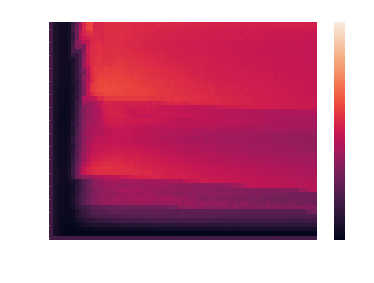

In [10]:
ax_sigma = sns.heatmap(sigma_table, annot=False, vmax = 1)
ax_sigma.set_title('Sigma as an Order parameter')
ax_sigma.invert_yaxis()

In [11]:
fig = ax_sigma.get_figure()
fig.savefig(os.path.join(target_path, 'sigma_phase_space.png'), dpi = 1000)

# Amin Saman Parameter

In [12]:
if neuron_model == 'Rotational':
    amin_saman_param_table = dict_to_dataframe(amin_saman_param_glossary_dict)
    ax_field_period = sns.heatmap(amin_saman_param_table)
    ax_field_period.set_title('AminSaman as an Order parameter ')
    fig = ax_field_period.get_figure()
    fig.savefig(os.path.join(target_path, 'amin_saman_phase_space.png'))

# Field period dataframe

In [13]:
field_period_table = dict_to_dataframe(field_period_glossary_dict)
field_period_table

connectivity,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,...,6.3,6.4,6.5,6.6,6.7,6.8,6.9,7.0,7.2,7.3
delay,,,,,,,,,,,,,,,,,,,,,
0.00,0.475023,0.475023,0.459982,0.455013,0.455013,0.474969,0.459982,0.455013,0.455013,0.455013,...,0.459982,0.455013,0.455013,0.459982,0.450045,0.450045,0.459982,0.475023,0.459982,0.455013
0.02,0.455013,0.475001,0.504972,0.535038,0.539957,0.569978,0.585008,0.610045,0.330533,0.041684,...,0.110181,0.145164,0.114039,0.223562,0.117143,0.174194,0.154656,0.189133,0.122185,0.166901
0.04,0.455013,0.490038,0.520021,0.520021,0.539957,0.569978,0.580046,0.083294,0.083400,0.083897,...,0.155600,0.235888,0.156925,0.159249,0.161486,0.161474,0.162604,0.163214,0.166154,0.167413
0.06,0.455013,0.494973,0.500000,0.545006,0.339977,0.139997,0.121090,0.123890,0.124156,0.126695,...,0.233323,0.233520,0.234443,0.237220,0.241083,0.240704,0.242200,0.244987,0.248760,0.250109
0.08,0.455013,0.485016,0.500000,0.529989,0.369948,0.374985,0.163080,0.162523,0.165369,0.165989,...,0.310662,0.314027,0.314565,0.317058,0.319298,0.320308,0.324625,0.327398,0.326014,0.330472
0.10,0.455013,0.494978,0.524981,0.524981,0.188339,0.203355,0.205932,0.201654,0.207836,0.210971,...,0.398486,0.398328,0.402586,0.405765,0.408756,0.415548,0.422308,0.419746,0.424811,0.426171
0.12,0.455013,0.484962,0.250000,0.269978,0.410017,0.284989,0.244234,0.243725,0.243881,0.248540,...,0.461042,0.463716,0.465564,0.464920,0.465984,0.521035,0.529019,0.592447,0.600603,0.909275
0.14,0.474969,0.475001,0.500000,0.260010,0.277480,0.286210,0.289024,0.296824,0.303859,0.310270,...,0.606066,0.911497,0.610512,0.934023,0.928036,0.631338,0.633516,0.952400,0.963456,0.654665
0.16,0.459982,0.484962,0.500000,0.297481,0.312486,0.312081,0.320844,0.321711,0.329002,0.333334,...,0.644602,0.630916,0.645338,0.652396,0.652787,0.669320,0.647673,0.691334,0.664894,0.666669


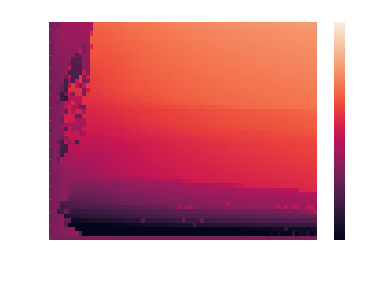

In [14]:
ax_field_period = sns.heatmap(np.log(field_period_table.abs()), annot=False, vmax = 2, vmin = -2)
ax_field_period.set_title('Logarithm of field period time')
ax_field_period.invert_yaxis()

In [15]:
fig = ax_field_period.get_figure()
fig.savefig(os.path.join(target_path, 'field_period_phase_space.png'))

In [16]:
max_intensity_table = dict_to_dataframe(field_max_intensity_mod_glossary_dict)
max_intensity_table

connectivity,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,...,6.3,6.4,6.5,6.6,6.7,6.8,6.9,7.0,7.2,7.3
delay,,,,,,,,,,,,,,,,,,,,,
0.00,2055.506566,2011.722169,2039.166217,2094.193868,2224.872464,2159.498574,2287.757066,2012.395528,2366.488751,2170.540169,...,2115.793993,2048.336692,2200.847761,2171.328869,2033.522729,2131.204415,2194.440517,2190.778836,2138.660561,2354.594263
0.02,2137.642172,1139.975294,805.908657,544.046110,440.532006,271.262356,191.938739,123.401762,65.926461,68.223132,...,76.913357,77.633283,73.249642,79.698905,75.020405,73.967496,86.318079,79.084373,82.868579,83.364628
0.04,2049.904755,1086.877702,739.856052,549.432383,405.199326,277.075330,131.612867,139.838686,177.758084,282.670706,...,515.576829,526.206346,622.290039,695.604234,573.367660,543.415667,555.104647,605.335943,433.931824,593.865011
0.06,2167.479003,1134.747526,847.715832,521.084650,382.736499,250.498911,225.723208,473.974742,595.122520,741.573717,...,977.141177,1104.358526,939.528091,1092.112774,988.406897,892.390786,957.474750,894.555181,989.858125,935.292352
0.08,2149.605515,1185.863194,922.350836,551.126345,467.179258,215.381581,333.282249,704.300731,974.982369,1069.309137,...,1377.274978,1581.063710,1770.748058,1273.047904,1453.489601,1385.796748,1497.953191,1372.554124,1164.302818,1346.945440
0.10,2257.767222,1106.148818,782.548228,554.999303,457.806772,280.576596,673.437287,1121.886293,1770.048615,2604.038067,...,2678.235529,2124.605191,2584.724061,1884.807687,2043.566176,2148.903000,1787.672583,1667.627286,1881.279908,1610.048287
0.12,2093.977711,1205.329135,1043.074136,764.852565,540.818748,314.993013,618.717690,1117.486969,1574.340894,1891.845797,...,2495.608415,2266.812094,2312.874877,2368.841587,2435.227539,2125.698089,2214.073287,4655.963287,3668.461121,5180.813630
0.14,2100.372186,1237.567077,973.653347,844.677668,837.708166,596.220864,1633.987148,4152.446088,4617.768658,2762.022998,...,8234.486783,8380.855821,6653.585675,8003.969923,7811.191629,9232.267962,7168.131815,7874.657831,9533.240923,11075.625326
0.16,2029.901291,1313.354881,1002.295707,703.515601,475.926321,507.234575,1382.527485,1954.580427,3650.674277,8241.257691,...,8489.492540,5622.472014,5891.642314,3979.912799,4386.416041,5453.839761,4394.392228,5064.576026,7217.746933,5198.051736


<IPython.core.display.Javascript object>


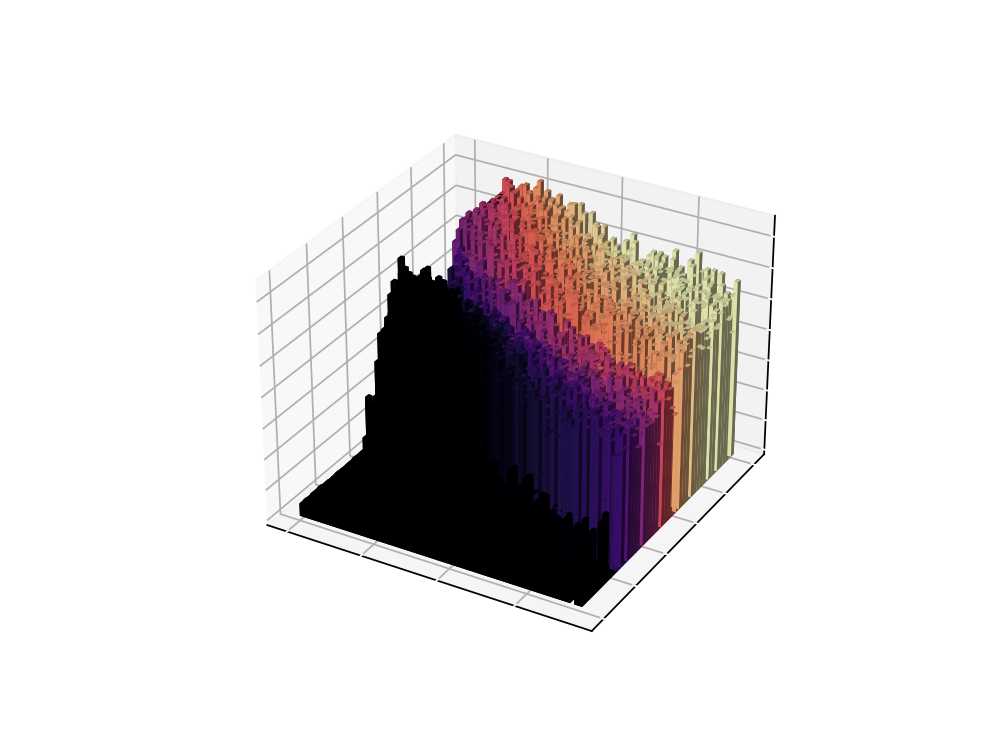

In [17]:
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D

d_arr = max_intensity_table.index
g_arr = max_intensity_table.columns
bars_pos = np.array([np.tile(g_arr, len(d_arr)), np.repeat(d_arr, len(g_arr)), [0]*(len(d_arr)*len(g_arr))])

dd_arr = d_arr[1] - d_arr[0]
dg_arr = g_arr[1] - g_arr[0]

dmax_intensity = max_intensity_table.to_numpy().flatten()

cmap = plt.cm.get_cmap('magma') # Get desired colormap - you can change this!
period_arr = field_period_table.to_numpy().flatten()
max_height = np.max(period_arr)   # get range of colorbars so we can normalize
min_height = np.min(period_arr)
# scale each z to [0,1], and get their rgb values
rgba = [cmap( np.log( k ) ) for k in period_arr] 


fig = plt.figure()          #create a canvas, tell matplotlib it's 3d
ax = fig.add_subplot(111, projection='3d')
ax.bar3d(bars_pos[0], bars_pos[1], bars_pos[2], dg_arr, dd_arr, dmax_intensity, color=rgba)